# Additional results for Zeisel et al. 2015
1. Summary of cell type-disease association at the cell-type level.
2. Further UMAP for other diseases and traits
3. overlay spatial scores on UMAP.

In [1]:
%load_ext lab_black

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from IPython.display import display, Markdown, Latex
import sys
import seaborn as sns
from scdrs.method import test_gearysc
from tqdm import tqdm

sys.path.append("/n/home12/khou/holystore/")
import paper_utils

import scanpy as sc

sc.set_figure_params(dpi=150)
from scipy.stats import rankdata

In [2]:
URL_SUPP_TABLE = "https://www.dropbox.com/s/k4tkz981t4x1km5/supp-tables.xlsx?dl=1"

In [3]:
def calc_mc_pval(list_trait, stats="percentile_95"):

    df_obs = adata.obs

    assert stats in ["max", "percentile_99", "percentile_95", "percentile_90"]
    col_ctrl_norm_score = [f"ctrl_norm_score_{i}" for i in range(1000)]

    dict_mc_pval = {}
    for trait in list_trait:
        df_tmp = pd.read_csv(
            f"01_score_cell/score_file/zeisel_2015/{trait}.full_score.gz",
            sep="\t",
            index_col=0,
        )
        df_tmp = pd.merge(
            df_obs[["level1class"]], df_tmp, left_index=True, right_index=True
        )

        if stats == "max":
            stats_func = lambda x: np.max(x)
        elif stats == "percentile_99":
            stats_func = lambda x: np.percentile(x, 99)
        elif stats == "percentile_95":
            stats_func = lambda x: np.percentile(x, 95)
        elif stats == "percentile_90":
            stats_func = lambda x: np.percentile(x, 90)
        else:
            raise NotImplementedError
        df_tmp = df_tmp.groupby("level1class").agg(
            {
                trait: lambda x: stats_func(x)
                for trait in ["norm_score"] + col_ctrl_norm_score
            }
        )

        rank_score = rankdata(df_tmp.values, axis=1)
        mc_pval = pd.Series(
            1 - (rank_score[:, 0] - 1) / rank_score.shape[1], index=df_tmp.index
        )
        dict_mc_pval[trait] = mc_pval
    df_mc_pval = pd.DataFrame(dict_mc_pval).T
    df_mc_pval.columns.name = None
    return df_mc_pval


def celltype_display_name(x):
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x
    name += f" ({df_celltype_n_cell[x]})"
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        return f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        return dict_trait_name[x]


def asterisk_display(x):
    if x < 0.05:
        return "×"
    else:
        return ""


from matplotlib.patches import Rectangle
import matplotlib.patches as patches


def small_squares(ax, pos, size=1, linewidth=0.8):
    """
    Draw many small squares on ax, given the positions of
    these squares.

    """
    for xy in pos:
        x, y = xy
        margin = (1 - size) / 2
        rect = patches.Rectangle(
            (x + margin, y + margin),
            size,
            size,
            linewidth=linewidth,
            edgecolor="k",
            facecolor="none",
            zorder=20,
        )
        ax.add_patch(rect)

In [4]:
display_trait_list = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "PASS_BIP_Mullins2021",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
]


df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

In [5]:
dataset = "zeisel_2015"
processed_dir = "00_prepare_dataset/processed"
adata = sc.read_h5ad(join(processed_dir, f"{dataset}.processed.h5ad"))

df_trs_pval = dict()
for trait in display_trait_list:
    df_trait_score = pd.read_csv(
        join("01_score_cell/score_file", dataset, f"{trait}.score.gz"),
        sep="\t",
        index_col=0,
    )
    df_trs_pval[trait] = df_trait_score["pval"].reindex(adata.obs.index)
df_trs_pval = pd.DataFrame(df_trs_pval)

df_fdr_prop = paper_utils.agg_trs_pval(
    df_obs=adata.obs.copy(),
    df_pval=df_trs_pval,
    stats="fdr_prop",
    groupby="level1class",
    fdr_prop_threshold=0.1,
)

dict_df_gearysc = dict()
for trait in tqdm(display_trait_list):
    df_score_full = pd.read_csv(
        join("01_score_cell/score_file", dataset, f"{trait}.full_score.gz"),
        sep="\t",
        index_col=0,
    ).reindex(adata.obs.index)
    dict_df_gearysc[trait] = test_gearysc(adata, df_score_full, "level1class")

  0%|          | 0/8 [00:00<?, ?it/s]/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 8/8 [05:12<00:00, 39.11s/it]


In [6]:
dict_celltype_display_name = {
    "pyramidal_CA1": "Pyramidal CA1",
    "oligodendrocytes": "Oligodendrocyte",
    "pyramidal_SS": "Pyramidal SS",
    "interneurons": "Interneuron",
    "endothelial-mural": "Endothelial",
    "astrocytes_ependymal": "Astrocyte",
    "microglia": "Microglia",
}

In [7]:
from statsmodels.stats.multitest import multipletests

df_gearysc_fdr = pd.DataFrame(
    {trait: dict_df_gearysc[trait]["pval"] for trait in dict_df_gearysc}
)

# convert to FDR
df_gearysc_fdr = pd.DataFrame(
    multipletests(df_gearysc_fdr.values.flatten(), method="fdr_bh")[1].reshape(
        df_gearysc_fdr.shape
    ),
    index=df_gearysc_fdr.index,
    columns=df_gearysc_fdr.columns,
).T

df_gearysc_fdr.columns = [col.replace(" ", "_") for col in df_gearysc_fdr.columns]

In [8]:
df_ct_pval = calc_mc_pval(display_trait_list)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)
df_ct_fdr.columns = [c.replace(" ", "_") for c in df_ct_fdr.columns]

<ipython-input-9-f0a2b829c203>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-9-f0a2b829c203>:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


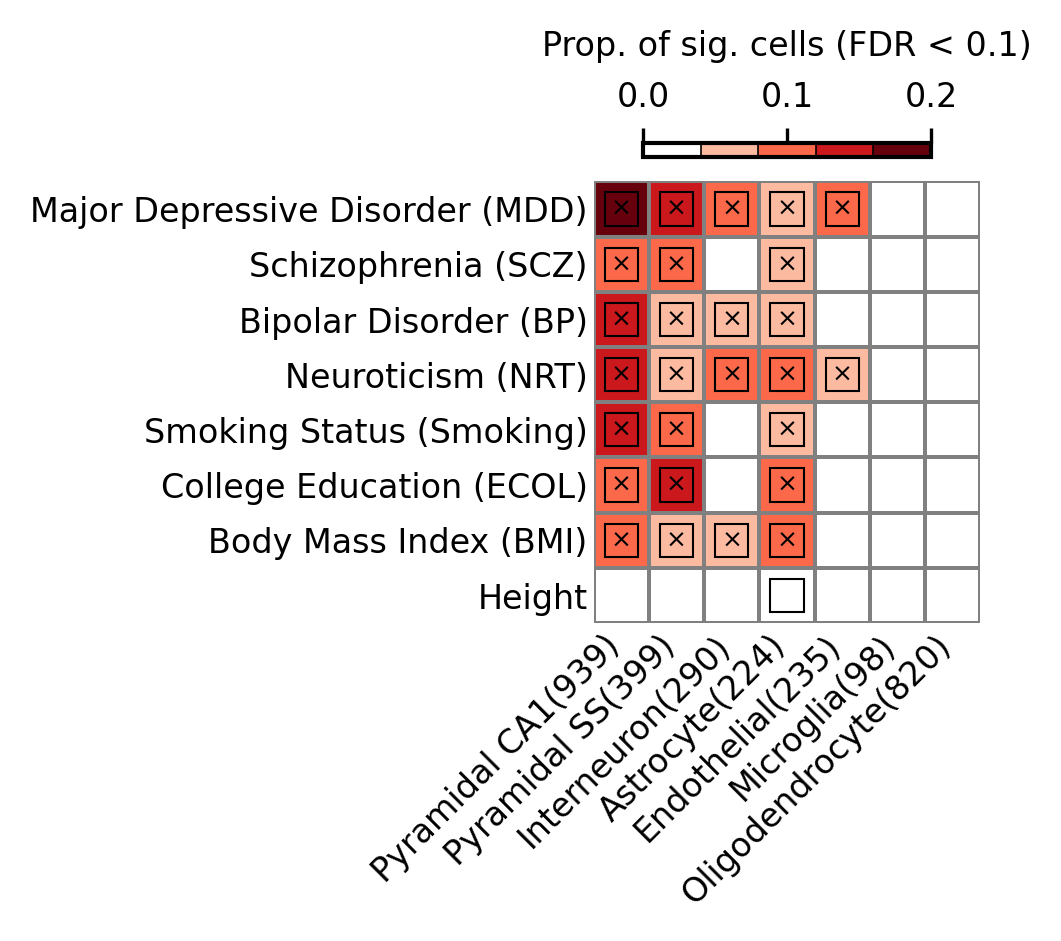

In [9]:
df_celltype_n_cell = adata.obs.level1class.value_counts()
df_celltype_n_cell.index = [c.replace(" ", "_") for c in df_celltype_n_cell.index]

df_plot = df_fdr_prop[
    [
        "pyramidal_CA1",
        "pyramidal_SS",
        "interneurons",
        "astrocytes_ependymal",
        "endothelial-mural",
        "microglia",
        "oligodendrocytes",
    ]
].copy()

df_gearysc_plot = df_gearysc_fdr.loc[df_plot.index, df_plot.columns].copy()
df_ct_fdr = df_ct_fdr.loc[df_plot.index, df_plot.columns].copy()
df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
df_gearysc_annot[df_ct_fdr > 0.05] = ""


df_plot = df_plot.rename(
    index=trait_display_name,
    columns=lambda x: dict_celltype_display_name[x] + f"({df_celltype_n_cell[x]})",
)

fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=30,
    heatmap_annot=df_gearysc_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.03, pad=0.05, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=0.2,
    colormap_n_bin=5,
)

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)

cb = ax.collections[0].colorbar
cb.ax.tick_params(labelsize=8)

cb.ax.set_title("Prop. of sig. cells (FDR < 0.1)", fontsize=8)
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)

plt.tight_layout()

plt.savefig("results/zeisel_assoc.pdf", bbox_inches="tight")

plt.show()

In [10]:
from functools import reduce

with pd.ExcelWriter("results/numeric_supp_tables.xlsx") as writer:
    df1 = df_fdr_prop.copy()
    df2 = df_ct_fdr.loc[df1.index, df1.columns].copy()
    df3 = df_gearysc_fdr.loc[df1.index, df1.columns]
    df1 = df1.melt(ignore_index=False).reset_index()
    df2 = df2.melt(ignore_index=False).reset_index()
    df3 = df3.melt(ignore_index=False).reset_index()
    df = reduce(
        lambda left, right: pd.merge(
            left, right, on=["index", "variable"], how="outer"
        ),
        [df1, df2, df3],
    )

    df.columns = [
        "trait",
        "cell-type",
        "prop-sig-cells",
        "ct-assoc-fdr",
        "heterogeneity-fdr",
    ]
    df.to_excel(writer, sheet_name="zeisel", float_format="%.2g", index=False)

    worksheet = writer.sheets["zeisel"]  # pull worksheet object
    for idx, col in enumerate(df):  # loop through all columns
        series = df[col]
        max_len = (
            max(
                (
                    series.astype(str).map(len).max(),  # len of largest item
                    len(str(series.name)),  # len of column name/header
                )
            )
            + 1
        )  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width

In [11]:
dataset = "zeisel_2015"
adata_dir = "00_prepare_dataset/processed/"
adata = sc.read_h5ad(join(adata_dir, "zeisel_2015.processed.h5ad"))
adata = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])]

spatial_cols = [
    "spatial_dorsal",
    "spatial_ventral",
    "spatial_proximal",
    "spatial_distal",
    "spatial_deep",
    "spatial_superficial",
]
df_list = []
for col in spatial_cols:
    temp_df = pd.read_csv(
        join("01_score_cell/score_file", dataset, f"{col}.score.gz"),
        sep="\t",
        index_col=0,
    )
    temp_df.columns = ["%s.%s" % (col, x) for x in temp_df.columns]
    df_list.append(temp_df)

df_spatial_score = pd.concat(df_list, axis=1)
df_spatial_score = df_spatial_score[
    [col for col in df_spatial_score if col.endswith(".norm_score")]
].rename(columns=lambda c: c[:-11])

for spatial_col in df_spatial_score.columns:
    adata.obs[spatial_col] = df_spatial_score[spatial_col].reindex(adata.obs.index)

Trying to set attribute `.obs` of view, copying.


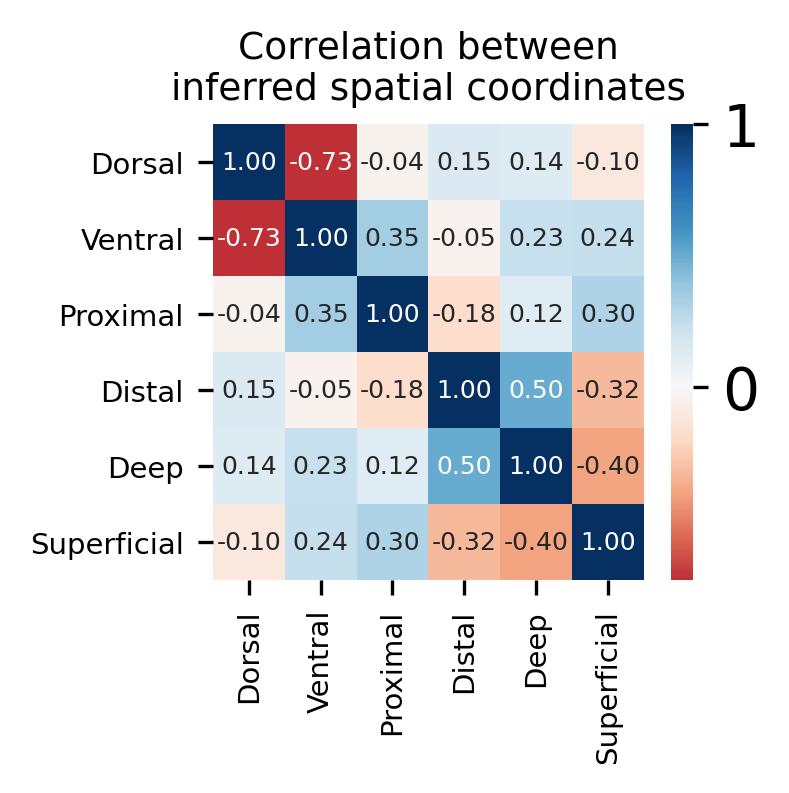

In [12]:
df_corr = (
    adata.obs[spatial_cols]
    .corr()
    .rename(columns=lambda x: x[8:].capitalize(), index=lambda x: x[8:].capitalize())
)
fig, ax = plt.subplots(dpi=150, figsize=(2.3, 2))
h = sns.heatmap(
    df_corr, center=0, cmap="RdBu", ax=ax, annot=True, fmt=".2f", annot_kws={"size": 6}
)

h.set_xticklabels(h.get_xmajorticklabels(), fontsize=7)
h.set_yticklabels(h.get_ymajorticklabels(), fontsize=7)
ax.set_title("Correlation between\ninferred spatial coordinates", fontsize=9)
plt.savefig("results/spatial_correlation.pdf", bbox_inches="tight")